## Building a training set

This notebook shows implementation of loading FITs files from a directory and building a 3D array containing the images to be used as a training set for a Neural network.

### Contents

1. [Displaying images](#display)
2. [Functions](#funcs)

In [1]:
import numpy as np
import os
from astropy.io import fits 
from astropy import stats
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
import pandas as pd

<a id='display'></a>
### Display images in directory

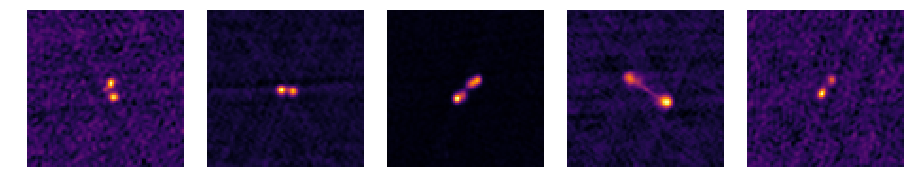

In [2]:
directory_path = r'C:\Users\JakeM\Google Drive\University of Birmingham\Year 4\Project\5. Code\Data\FITS agn'
directory = os.fsencode(directory_path)

files = [f for f in os.listdir(directory_path) if f.endswith('.fits')] # list of FITs filenames in directory
n = 5 # number of objects to display
cols = 5 # number of images per row

fig = plt.figure(figsize=(12.5,(n+cols-1)//cols*2.5))
for i in range(n):
    ax = fig.add_subplot((n+cols-1)//cols, cols, i+1)
    filename = os.fsdecode(files[i])
    filepath = os.path.join(directory_path, filename) # or #filepath = directory_path + '\\' + filename
    data = fits.getdata(filepath, ext=0)
    ax.imshow(data, cmap='inferno')
    plt.axis('off')
fig.tight_layout(pad=0)
plt.show()

<a id='funcs'></a>
### Functions

Functions to load FITs images into 3D array to be used as a training set. Options for sigma clipping and augmenting the data sets. Functions able to deal with exceptions, such as some images from the .txt file with object locations not being downloaded into the directory (see Webscrape FITs files for more context), and some downloaded images being filled with nan values when image is on a boundary of the survey. 'Bad images' i.e. ones with lots of nan values are removed from the training set. The .txt file with all the expected images is compared to the images in the directory to identify the objects that weren't downloaded, and to create an accurate .txt file which contains only the downloaded images.

Final training sets are saved to a .npy file, with the corresponding .txt file. 

In [3]:
def get_images(filepath):
    '''
    Load FITs images into 3D array from directory
    All images must be the same shape
    Removes any images with nan values
    '''
    filepath = filepath.replace(os.sep, '/')
    files = [f for f in os.listdir(filepath) if f.endswith('.fits')]
    n = len(files)
    xpix, ypix = fits.getdata(filepath+'/'+files[0], ext=0).shape
    data = np.empty(shape=(n,xpix,ypix),dtype=np.float64)
    nan_indices = []
    for i in range(n):
        if i%500==0: print(i) # to show progress
        fullpath = '{}/{}'.format(filepath,files[i])
        data[i,:,:] = fits.getdata(fullpath, ext=0)
        #data[i,:,:][np.isnan(data[i,:,:])] = 0
        if np.isnan(data[i,:,:]).any(): nan_indices.append(i)
    return np.delete(data, nan_indices, axis=0), nan_indices

def find_missing(txt_path, filepath, nan_indices=[]):
    '''
    Compare a txt file with object RAs with the RAs of the downloaded objects to find the missing 
    indices in the txt file. Can also add nan_indices list for indices of files which were downloaded, 
    but not used in data set since contained nan values.
    '''
    txt_ra = np.squeeze(np.array(pd.read_csv(txt_path, sep='\s+', header=None, usecols=[1])))
    txt_ra = np.around(txt_ra, 5)
    files = [f for f in os.listdir(filepath) if f.endswith('.fits')]
    files = np.delete(files, nan_indices)
    files_ra = np.empty(len(files))
    for i in range(len(files)):
        ra = fits.getval(directory_path + '\\' + files[i], 'OBJCTRA')
        hours, mins, secs = int(ra[:2]), int(ra[3:5]), float(ra[6:12])
        ra_deg = (hours+mins/60+secs/3600)*(360/24) # convert RA from hh:mm:ss to degrees (i.e. decimal)
        ra_deg = round(ra_deg, 5)
        files_ra[i] = ra_deg
    missing_i = np.squeeze([np.argwhere(txt_ra==ra) for ra in txt_ra if ra not in files_ra])
    return missing_i

def clip_images(data, sigma, indv=True):
    '''
    Sigma clips images. 
    Gives choice of clipping images individually, or all together. (i.e. if all together then all
    images will have the same background value)
    '''
    if indv:
        for i in range(len(data)):
            _,median,std = stats.sigma_clipped_stats(data[i], sigma=sigma)
            data[i][data[i]<median+sigma*std] = median+sigma*std
    else:
        _,median,std = stats.sigma_clipped_stats(data, sigma=sigma)
        data[data<median+sigma*std] = median+sigma*std
    return data

def norm_images(data):
    '''
    Normalises the images to range [-1,1]
    '''
    for i in range(len(data)):
        data[i] = 2*(data[i]-np.min(data[i]))/np.ptp(data[i])-1
    return data

def get_norm_clipped_images(filepath, sigma):
    '''
    Load FITs images into 3D array from directory
    All images must be the same shape
    Removes any images with nan values
    Sigma clips (indv) and normalises the images [-1,1]
    '''
    filepath = filepath.replace(os.sep, '/')
    files = [f for f in os.listdir(filepath) if f.endswith('.fits')]
    n = len(files)
    xpix, ypix = fits.getdata(filepath+'/'+files[0], ext=0).shape
    data = np.empty(shape=(n,xpix,ypix),dtype=np.float64)
    nan_indices = []
    for i in range(n):
        if i%500==0: print(i) # to show progress
        fullpath = '{}/{}'.format(filepath,files[i])
        d = fits.getdata(fullpath, ext=0)
        if np.isnan(d).any(): nan_indices.append(i)
        #d[np.isnan(d)] = 0 # sets nan values to zero
        else:
            _,median,std = stats.sigma_clipped_stats(d, sigma=sigma)
            d[d<median+sigma*std] = median+sigma*std
            d = 2*(d-np.min(d))/np.ptp(d)-1
            data[i,:,:] = d
    return np.delete(data, nan_indices, axis=0), nan_indices

def augment_data(data, size):
    '''
    Augment the data (3D array of images) by flipping and rotating the images.
    Size = upper bound on the final number of images 
    (actual_size can be much less depending on size/data_size multiples)
    TODO: Make the actual size = size
    Make sure still works if size<len(data)
    '''
    rotations = size//len(data) # rotations per image
    angles = np.linspace(0, 360, rotations)
    act_size = rotations*len(data)
    xpix, ypix = data[0].shape
    training_set = np.empty((act_size, xpix, ypix))
    for i in range(len(data)):
        for j in range(len(angles)):
            if j % 2 == 0: training_set[i*len(angles)+j,:,:] = rotate(np.fliplr(data[i,:,:]), angles[j], reshape=False)
            else: training_set[i*len(angles)+j,:,:] = rotate(data[i,:,:], angles[j], reshape=False)
    return training_set

def train_test(data, percentage):
    '''
    Combines data sets into one 3D array, with a different label for each data set.
    Then randomly shuffles the data and splits into training and test sets.
    data = list of 3D arrays containing desired data sets
    percentage = fraction of data to be in training set
    returns: train and test data (each a tupple containing the data and corresponding labels)
    '''
    d = np.concatenate(data,axis=0)
    n_images = len(d)
    labels = np.empty(n_images)
    i = 0
    for n in range(len(data)):
        labels[i:i+len(data[n])] = n
        i += len(data[n])
    rand_ind = np.random.permutation(range(n_images))
    d, labels = d[rand_ind], labels[rand_ind]
    n_train = np.int(np.round(n_images*percentage))
    train = (d[:n_train], labels[:n_train])
    test = (d[n_train:], labels[n_train:])
    return train, test

In [4]:
# Load data into 3D array, and find images with nan values
agn_path = r'C:\Users\JakeM\Google Drive\University of Birmingham\Year 4\Project\5. Code\Data\FITS agn'
agn_data, nan_indices = get_images(agn_path)

# Find missing data indices from txt file
txt_path = r'C:\Users\JakeM\Google Drive\University of Birmingham\Year 4\Project\5. Code\Data\GaronAGN2019_RA_dec.txt'
missing_i = find_missing(txt_path, agn_path, nan_indices)

# Delete the missing object's angles to get list corresponding to data array
ang_path = r'C:\Users\JakeM\Google Drive\University of Birmingham\Year 4\Project\5. Code\Data\agn bending angle.txt'
agn_ang = np.array(pd.read_csv(ang_path, sep='\s+', header=None, usecols=[2])) # bending angle of agn, from vizier catalog
agn_ang = np.delete(agn_ang, missing_i)
len(agn_ang), len(agn_data), len(os.listdir(agn_path)) # images with nan values still in directory

0
500
1000
1500
2000
2500
3000
3500


(3705, 3705, 3712)

In [5]:
# Normalise and sigma clip the images
agn_data_clipped_indv = get_norm_clipped_images(agn_path, 3)

0
500
1000
1500
2000
2500
3000
3500


In [6]:
# Save useful data
np.save('agn_data', agn_data)
np.save('agn_data_clipped_indv', agn_data_clipped_indv)
np.save('agn_ang', agn_ang)